#verify pyEMU null space projection with the freyberg problem

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu

setting random seed


instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [24]:
mc = pyemu.MonteCarlo(jco="freyberg.jcb",verbose=False,forecasts=[])
mc.drop_prior_information()
jco_ord = mc.jco.get(mc.pst.obs_names,mc.pst.par_names)
ord_base = "freyberg_ord"
jco_ord.to_binary(ord_base + ".jco")  
mc.pst.control_data.parsaverun = ' '
mc.pst.write(ord_base+".pst")
nsing = 5

Draw some vectors from the prior and write the vectors to par files

In [25]:
# setup the dirs to hold all this stuff
par_dir = "prior_par_draws"
proj_dir = "proj_par_draws"
parfile_base = os.path.join(par_dir,"draw_")
projparfile_base = os.path.join(proj_dir,"draw_")
if os.path.exists(par_dir):
   shutil.rmtree(par_dir)
os.mkdir(par_dir)
if os.path.exists(proj_dir):
   shutil.rmtree(proj_dir)
os.mkdir(proj_dir)
mc = pyemu.MonteCarlo(jco=ord_base+".jco")
# make some draws
mc.draw(10)
#for i in range(10):
#    mc.parensemble.iloc[i,:] = i+1
#write them to files
mc.parensemble.index = [str(i+1) for i in range(mc.parensemble.shape[0])]
mc.parensemble.to_parfiles(parfile_base)
mc.parensemble.shape

(10, 761)

Run pnulpar

In [26]:
exe = os.path.join("pnulpar.exe")
args = [ord_base+".pst","y",str(nsing),"y","pnulpar_qhalfx.mat",parfile_base,projparfile_base]
in_file = os.path.join("misc","pnulpar.in")
with open(in_file,'w') as f:
    f.write('\n'.join(args)+'\n') 
os.system(exe + ' <'+in_file)


0

In [27]:
pnul_en = pyemu.ParameterEnsemble(mc.pst)
parfiles =[os.path.join(proj_dir,f) for f in os.listdir(proj_dir) if f.endswith(".par")]
pnul_en.read_parfiles(parfiles)

In [28]:
pnul_en.loc[:,"fname"] = pnul_en.index
pnul_en.index = pnul_en.fname.apply(lambda x:str(int(x.split('.')[0].split('_')[-1])))
f = pnul_en.pop("fname")

In [29]:

pnul_en.sort_index(axis=1,inplace=True)
pnul_en.sort_index(axis=0,inplace=True)
pnul_en

parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
fname,,,,,,,,,,,,,,,,,,,,,
1,4.186738,0.594751,21.758200,16.079500,25.288040,2.903054,21.250090,39.294870,0.594751,15.296770,...,318.8160,601.905,313.5065,430.666,64.54079,101.6830,59.79505,62.1055,408.6720,293.009
10,0.594751,0.594751,0.594751,6.809739,0.594751,12.833140,2.036831,0.594751,17.834370,7.477574,...,318.8160,527.963,303.2640,627.652,64.54079,111.5560,68.42880,84.9680,350.7305,538.019
2,14.833210,0.594751,0.594751,17.231210,0.594751,2.575262,18.042960,4.913288,0.594751,0.594751,...,389.6640,270.968,354.3414,516.138,78.88320,62.2400,64.11827,63.1377,375.6014,441.645
3,3.827683,41.227750,5.719348,0.594751,12.558840,0.594751,7.575644,8.564014,0.594751,26.344510,...,389.6640,221.400,370.6560,392.759,73.19645,69.1781,55.98720,65.9769,408.6720,426.659
4,20.924240,33.729610,31.144030,15.822050,11.960280,52.619510,0.594751,15.484890,0.594751,20.816730,...,318.8160,272.902,303.2640,470.431,75.65316,81.4102,68.42880,82.7693,394.4708,594.299
5,0.594751,6.950879,0.594751,0.594751,16.923890,3.138126,20.398130,13.010450,6.863224,0.594751,...,330.7119,530.168,303.2640,477.313,64.54079,91.2734,68.42880,95.2010,351.9224,470.932
6,1.647486,0.594751,6.089208,5.985260,0.594751,9.757670,6.794196,0.594751,3.944095,0.594751,...,318.8160,498.503,304.8966,509.310,78.88320,70.4792,68.42880,51.0144,336.8991,558.205
7,1.878035,7.258989,2.269877,17.647400,4.787173,5.742796,0.594751,0.594751,3.159746,11.390120,...,371.2686,640.489,311.2821,369.478,64.54079,67.0163,55.98720,80.1758,385.8373,370.866
8,0.929028,0.594751,0.594751,7.177981,0.594751,17.807460,1.582090,3.600920,0.594751,17.978510,...,389.6640,306.948,352.1817,463.635,78.88320,87.5798,68.42880,112.8330,334.3680,271.104


Now for pyemu

In [30]:
print(mc.parensemble.istransformed)
mc.parensemble._transform()
en = mc.project_parensemble(nsing=nsing,inplace=False)
print(mc.parensemble.istransformed)
#en._back_transform()

False
using 5 singular components
True


In [31]:
en.sort_index(axis=1,inplace=True)
en.sort_index(axis=0,inplace=True)
en

parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
1,4.18674,0.594751,21.7582,16.0795,25.288,2.90305,21.2501,39.2948,0.594751,15.2968,...,318.816,601.905,313.506,430.666,64.5408,101.683,59.7951,62.1055,408.672,293.009
10,0.594751,0.594751,0.594751,6.80974,0.594751,12.8332,2.03683,0.594751,17.8343,7.47758,...,318.816,527.963,303.264,627.652,64.5408,111.556,68.4288,84.968,350.731,538.019
2,14.8332,0.594751,0.594751,17.2312,0.594751,2.57526,18.043,4.91328,0.594751,0.594751,...,389.664,270.968,354.341,516.138,78.8832,62.24,64.1182,63.1377,375.601,441.645
3,3.82768,41.2277,5.71935,0.594751,12.5589,0.594751,7.57565,8.56402,0.594751,26.3445,...,389.664,221.4,370.656,392.759,73.1964,69.1781,55.9872,65.9769,408.672,426.659
4,20.9242,33.7297,31.1441,15.822,11.9603,52.6195,0.594751,15.4849,0.594751,20.8168,...,318.816,272.902,303.264,470.431,75.6531,81.4102,68.4288,82.7693,394.471,594.299
5,0.594751,6.95088,0.594751,0.594751,16.9239,3.13812,20.3981,13.0105,6.86323,0.594751,...,330.712,530.168,303.264,477.313,64.5408,91.2734,68.4288,95.201,351.922,470.932
6,1.64748,0.594751,6.0892,5.98526,0.594751,9.7577,6.79419,0.594751,3.94409,0.594751,...,318.816,498.503,304.896,509.31,78.8832,70.4792,68.4288,51.0144,336.899,558.205
7,1.87804,7.25899,2.26988,17.6474,4.78718,5.74279,0.594751,0.594751,3.15975,11.3901,...,371.268,640.489,311.282,369.478,64.5408,67.0163,55.9872,80.1758,385.837,370.866
8,0.929029,0.594751,0.594751,7.17798,0.594751,17.8075,1.58209,3.60092,0.594751,17.9785,...,389.664,306.948,352.182,463.635,78.8832,87.5798,68.4288,112.833,334.368,271.104
9,13.9657,0.594751,16.3196,0.594751,0.594751,0.594751,28.7507,0.594751,8.76207,9.73485,...,389.664,318.466,304.26,444.031,64.5408,106.924,55.9872,57.0439,408.672,344.775


parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
fname,,,,,,,,,,,,,,,,,,,,,
1,0.000103857,1.8667e-14,0.000205326,0.00022812,0.000151888,0.00011362,0.000162355,8.34917e-05,1.8667e-14,0.000122344,...,0,1.66797e-05,0.000128261,9.61527e-05,0,0.000329094,3.76707e-05,7.20012e-05,0,2.48395e-05
10,1.8667e-14,1.8667e-14,1.8667e-14,3.17821e-05,1.8667e-14,0.000254293,0.000175981,1.8667e-14,0.000157264,0.0001427,...,0,6.80812e-05,0,4.27749e-05,0,6.17243e-05,0,1.93522e-05,2.65807e-05,1.26393e-05
2,0.000204107,1.8667e-14,1.8667e-14,0.000272924,1.8667e-14,4.98822e-05,0.000282224,0.000114383,1.8667e-14,1.8667e-14,...,0,5.47912e-05,9.3874e-06,1.96215e-05,0,7.27191e-05,3.27463e-05,4.54522e-05,6.04764e-06,8.33983e-05
3,2.80997e-05,0.000105225,9.18641e-05,1.8667e-14,0.000333159,1.8667e-14,9.85315e-05,1.91931e-05,1.8667e-14,6.80387e-05,...,0,0,0,5.76116e-06,7.61591e-05,8.11135e-06,0,7.19477e-05,0,9.7338e-05
4,2.73585e-05,0.000130741,7.93943e-05,0.0001836,0.000125253,3.5486e-05,1.8667e-14,5.22386e-06,1.8667e-14,0.000169709,...,0,1.2589e-05,0,7.50303e-05,0.000140416,4.23249e-05,0,5.73468e-05,2.7691e-05,6.05752e-05
5,1.8667e-14,5.51009e-05,1.8667e-14,1.8667e-14,7.96102e-05,7.09053e-05,8.21079e-05,0.000400378,2.09698e-05,1.8667e-14,...,0.00011361,6.80498e-05,0,1.02239e-05,0,7.35846e-06,0,1.23736e-05,2.13983e-05,2.80357e-05
6,0.000247274,1.8667e-14,8.55815e-05,1.97828e-05,1.8667e-14,0.000350963,8.75733e-05,1.8667e-14,4.15681e-05,1.8667e-14,...,0,8.81009e-05,6.54484e-05,3.6441e-05,0,4.65753e-05,0,9.2566e-05,8.49063e-06,3.6443e-05
7,0.00021361,3.85269e-05,5.37664e-05,5.36666e-05,4.67794e-05,0.000103707,1.8667e-14,1.8667e-14,8.55748e-05,0.000129801,...,0.000152191,6.66576e-05,2.30775e-05,5.00171e-05,0,6.02309e-05,0,3.32837e-05,9.08097e-06,3.32992e-05
8,0.000101735,1.8667e-14,1.8667e-14,3.66175e-05,1.8667e-14,1.93635e-05,3.60803e-05,2.44554e-05,1.8667e-14,0.0001078,...,0,4.37842e-05,5.73997e-05,6.06327e-05,0,1.72577e-05,0,0.000224023,0,0.000164182


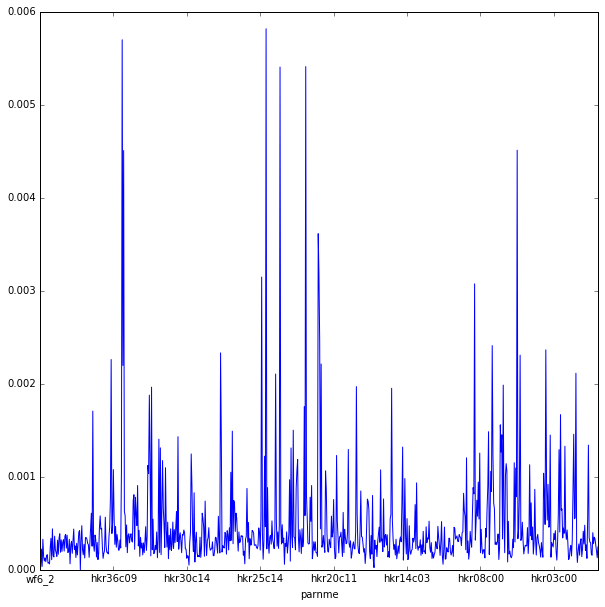

In [32]:
#pnul_en.sort(inplace=True)
#en.sort(inplace=True)
diff = 100.0 * np.abs(pnul_en - en) / en

#diff[diff<1.0] = np.NaN
dmax = diff.max(axis=0)
dmax.sort_index(ascending=False,inplace=True)
dmax.plot(figsize=(10,10))
diff

In [33]:
en.loc[:,"wf6_2"]

1     293.009
10    538.019
2     441.645
3     426.659
4     594.299
5     470.932
6     558.205
7     370.866
8     271.104
9     344.775
Name: wf6_2, dtype: object

In [34]:
pnul_en.loc[:,"wf6_2"]

fname
1     293.009
10    538.019
2     441.645
3     426.659
4     594.299
5     470.932
6     558.205
7     370.866
8     271.104
9     344.775
Name: wf6_2, dtype: float64